# NDPIA AI & infection poster

This is the code for a poster presented at the NDPIA AI & infection medicine conference 2024. It also serves as an example for anyone who wants to do simple experiments with BINN.

In [1]:
import pandas as pd

input_data = (
    pd.concat(
        [
            pd.read_csv("data/covid_train.tsv", sep="\t").set_index("Protein"),
            pd.read_csv("data/covid_test.txt", sep="\t").set_index("Protein"),
        ],
        axis=1,
    )
    .reset_index()
    .drop(columns=["Unnamed: 0"])
)
design_matrix = pd.concat(
    [
        pd.read_csv("data/covid_train_design.tsv", sep="\t"),
        pd.read_csv("data/covid_test_design.txt", sep="\t"),
    ]
)  # Use all data for getting importance

In [2]:
from binn import Network, BINN
import numpy as np
import torch
import random
from docs.util_for_examples import fit_data_matrix_to_network_input

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

translation = pd.read_csv("data/translation.tsv", sep="\t")
pathways = pd.read_csv("data/pathways.tsv", sep="\t")

network = Network(
    input_data=input_data,
    pathways=pathways,
    mapping=translation,
    source_column="child",
    target_column="parent",
)


binn = BINN(
    network=network,
    n_layers=3,
    dropout=0.2,
    validate=False,
    device="cpu",
    learning_rate=0.001,
)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



BINN is on the device: cpu


In [3]:
binn.trainable_params

1075

In [4]:
from docs.util_for_examples import generate_data
import torch

protein_matrix = fit_data_matrix_to_network_input(input_data, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=design_matrix)

dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32, device=binn.device),
    torch.tensor(y, dtype=torch.int16, device=binn.device),
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
from binn.explainer import BINNExplainer

explainer = BINNExplainer(binn)

In [6]:
test_data = torch.Tensor(X)
background_data = torch.Tensor(X)

n_iterations = 20
n_epochs = 30

importance_df, metrics = explainer.explain_average(
    test_data, background_data, n_iterations, n_epochs, dataloader, fast_train=True
)
metrics

Iteration 0
Final epoch: Average Accuracy 0.85, Average Loss: 0.34
Iteration 1
Final epoch: Average Accuracy 0.82, Average Loss: 0.38
Iteration 2
Final epoch: Average Accuracy 0.87, Average Loss: 0.32
Iteration 3
Final epoch: Average Accuracy 0.86, Average Loss: 0.32
Iteration 4
Final epoch: Average Accuracy 0.86, Average Loss: 0.33
Iteration 5
Final epoch: Average Accuracy 0.87, Average Loss: 0.31
Iteration 6
Final epoch: Average Accuracy 0.87, Average Loss: 0.31
Iteration 7
Final epoch: Average Accuracy 0.88, Average Loss: 0.31
Iteration 8
Final epoch: Average Accuracy 0.85, Average Loss: 0.35
Iteration 9
Final epoch: Average Accuracy 0.88, Average Loss: 0.29
Iteration 10
Final epoch: Average Accuracy 0.87, Average Loss: 0.30
Iteration 11
Final epoch: Average Accuracy 0.87, Average Loss: 0.32
Iteration 12
Final epoch: Average Accuracy 0.87, Average Loss: 0.30
Iteration 13
Final epoch: Average Accuracy 0.86, Average Loss: 0.33
Iteration 14
Final epoch: Average Accuracy 0.88, Average L

{0: {'accuracies': [0.6616161465644836,
   0.7613636255264282,
   0.7815656661987305,
   0.8005050420761108,
   0.8244949579238892,
   0.8194444179534912,
   0.8207070827484131,
   0.8358585834503174,
   0.8194444179534912,
   0.8194444179534912,
   0.8535353541374207,
   0.8434343338012695,
   0.8333333134651184,
   0.8459596037864685,
   0.8472222089767456,
   0.8522727489471436,
   0.8383838534355164,
   0.8320707082748413,
   0.8825757503509521,
   0.8497474789619446,
   0.8484848737716675,
   0.8244949579238892,
   0.8560606241226196,
   0.8585858345031738,
   0.8295454382896423,
   0.8446969985961914,
   0.8446969985961914,
   0.8446969985961914,
   0.8472222089767456,
   0.8547979593276978],
  'losses': [0.6232332391570313,
   0.5216682636075549,
   0.4792005772692989,
   0.4581012823665985,
   0.4251636561721262,
   0.4119017355971866,
   0.3931540964980318,
   0.35960981468058595,
   0.3866180104739738,
   0.4009530275608554,
   0.36700368401679123,
   0.3779328767247874,
   0

In [166]:
plot_df = importance_df.copy()

plot_df["copy"] = plot_df.apply(
    lambda x: True if x["source name"] == x["target name"] else False, axis=1
)
plot_df = plot_df[plot_df["copy"] == False]

id_to_name = pd.read_csv(
    "data/id_to_name.txt", sep="\t", names=["id", "name", "species"]
)
id_to_name = id_to_name[id_to_name["species"] == "Homo sapiens"]

human_proteome = pd.read_csv("data/human_proteome.gz")
proteome_mapping = (
    human_proteome.set_index("accession").drop(columns=["seq"]).to_dict()["trivname"]
)
mapping = id_to_name.drop(columns="species").set_index("id").to_dict()["name"]

mapping.update(proteome_mapping)

mapping.update({"root": "root"})

plot_df["source name"] = plot_df["source name"].map(mapping)
plot_df["target name"] = plot_df["target name"].map(mapping)
plot_df.sort_values("value", ascending=False).head(3)

,source,target,source name,target name,type,source layer,target layer,value_0,value_1,value_2,...,value_14,value_15,value_16,value_17,value_18,value_19,value_mean,values_std,value,copy
1530,289,0,Immune System,root,0,3,4,0.279172,0.366612,0.323244,...,0.626708,0.318696,0.552539,0.469431,0.513716,0.532028,0.415101,0.135087,0.415101,False
698,50,186,FIBB_HUMAN,Oncogenic MAPK signaling,0,0,1,0.129136,0.150088,0.365940,...,0.190413,0.263657,0.327202,0.423823,0.291233,0.370538,0.321445,0.099980,0.321445,False
700,50,193,FIBB_HUMAN,Response to elevated platelet cytosolic Ca2+,0,0,1,0.129136,0.150088,0.365940,...,0.190413,0.263657,0.327202,0.423823,0.291233,0.370538,0.321445,0.099980,0.321445,False


In [167]:
def translate(x):
    if not isinstance(x, str):
        return x
    if x.startswith("Response to ele"):
        return "Resp. to platelet Ca2+"
    elif x.startswith("Sensory processing of s"):
        return "Sens. proc. of sound"
    elif x.startswith("Miscellaneous transp"):
        return "Misc. transport & binding"
    elif x.startswith("Formation of Fibrin Clot"):
        return "Clotting cascade"
    elif x.startswith("Generic Tran"):
        return "Generic Transc. Path."
    elif x.startswith("Scavenging of heme"):
        return "Scavenging plasma-heme"
    else:
        return x
        

In [168]:
from binn import ImportanceNetwork
plot_df["source name"] = plot_df["source name"].apply(lambda x: translate(x))
plot_df["target name"] = plot_df["target name"].apply(lambda x: translate(x))
IG = ImportanceNetwork(plot_df, norm_method="subgraph")

In [177]:
IG.plot_complete_sankey(
    multiclass=False,
    savename="poster_binn.svg",
    node_cmap="coolwarm",
    edge_cmap="coolwarm",
    width=1200,
    height=400,
    show_top_n=5,
)

In [170]:
importance_df_copy = IG.importance_df.groupby(
    ["source name", "source layer", "target layer"], as_index=False
).mean(numeric_only=True)
mean_ranks = []
std_ranks = []
source_layer = []
sources = []
for layer in range(binn.n_layers + 1):
    layer_df = importance_df_copy[importance_df_copy["source layer"] == layer].copy()
    for i in range(n_iterations):
        layer_df.sort_values(f"value_{i}", ascending=False, inplace=True)
        layer_df[f"rank_{i}"] = range(len(layer_df.index))
    rank_cols = [c for c in layer_df.columns if c.startswith("rank")]
    mean_ranks += layer_df[rank_cols].mean(axis=1).tolist()
    sources += layer_df["source name"].tolist()
    std_ranks += layer_df[rank_cols].std(axis=1).tolist()
    source_layer += layer_df["source layer"].tolist()
robust_df = pd.DataFrame(
    {
        "mean": mean_ranks,
        "std": std_ranks,
        "source layer": source_layer,
        "source": sources,
    }
)

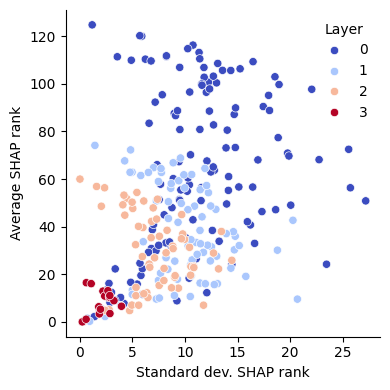

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.scatterplot(robust_df, y="mean", x="std", hue="source layer", palette="coolwarm")

plt.tight_layout()
sns.despine()
plt.legend(frameon=False, title="Layer")
plt.ylabel("Average SHAP rank")
plt.xlabel("Standard dev. SHAP rank")
plt.savefig("poster_robustness.png", dpi=500)

In [172]:
biomarkers = IG.importance_df[IG.importance_df["source layer"] == 0].copy()
biomarkers = biomarkers.groupby("source name").mean(numeric_only=True)
biomarkers = biomarkers.sort_values("value", ascending=False)["source"][
    0:5
].index.tolist()

/Users/erikhartman/dev/BINN/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



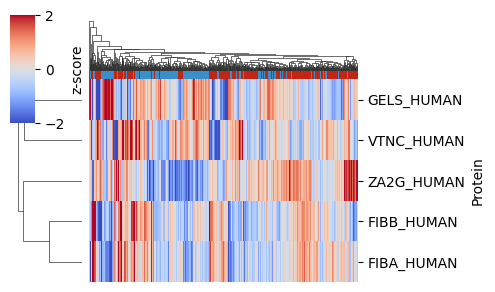

In [173]:
if "_HUMAN" not in protein_matrix.index[0]:
    protein_matrix.index = protein_matrix.index.map(mapping)

biomarker_data = protein_matrix.loc[biomarkers].fillna(0)

from sklearn.preprocessing import StandardScaler
from umap import UMAP

cols = biomarker_data.columns
index = biomarker_data.index
biomarker_data = StandardScaler().fit_transform(biomarker_data.T).T

X_reduced = UMAP(random_state=42).fit_transform(biomarker_data.T)

row_colors = design_matrix["group"].map({1: "#398fcc", 2: "#c42412"}).values

biomarker_data = pd.DataFrame(data=biomarker_data, columns=cols, index=index)

g = sns.clustermap(
    biomarker_data,
    col_colors=row_colors,
    figsize=(5, 6),
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
    cbar_kws={"label": "z-score"},
)
g.ax_heatmap.set_xticks([])

plt.savefig("poster_biomarkers.png", dpi=500)

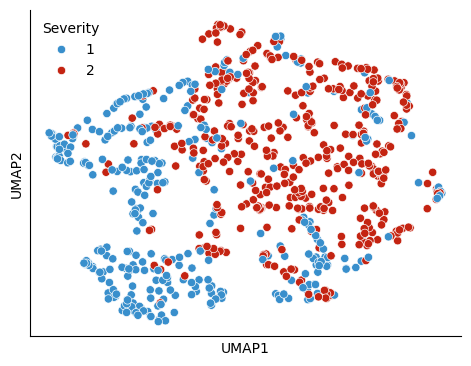

In [174]:
umap_df = pd.DataFrame(data=X_reduced, columns=["UMAP1", "UMAP2"])
umap_df["group"] = design_matrix["group"].values
umap_df.reset_index(inplace=True)


plt.figure(figsize=(5,4))
sns.scatterplot(umap_df, x="UMAP1", y ="UMAP2", hue="group", palette=["#398fcc", "#c42412"])
plt.legend(frameon=False, title="Severity")
sns.despine()
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.savefig("poster_biomarkers_umap.png", dpi=500)

In [175]:
query_node = "FIBB_HUMAN"

IG.plot_subgraph_sankey(
    query_node, upstream=False, savename="poster_subbinn.png", cmap="coolwarm"
)

    accuracies    losses  epoch  model
0     0.661616  0.623233      0      0
1     0.761364  0.521668      1      0
2     0.781566  0.479201      2      0
3     0.800505  0.458101      3      0
4     0.824495  0.425164      4      0
..         ...       ...    ...    ...
25    0.867424  0.301669     25     19
26    0.849747  0.333550     26     19
27    0.862374  0.325455     27     19
28    0.863636  0.321790     28     19
29    0.859848  0.317320     29     19

[600 rows x 4 columns]


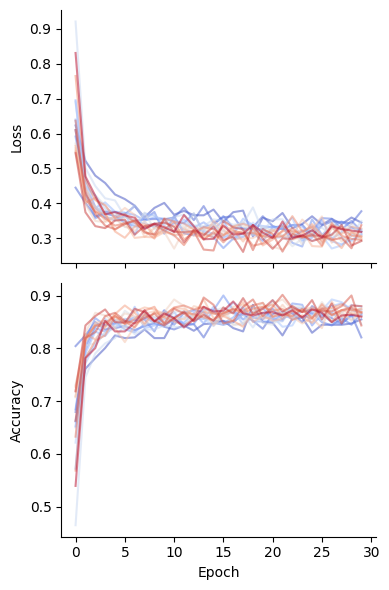

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

all_metrics = []

for model, metric in metrics.items():
    metric["model"] = [model] * len(metric["accuracies"])
    all_metrics.append(pd.DataFrame(metric))

all_metrics = pd.concat(all_metrics)
print(all_metrics)

fig, axs = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
sns.lineplot(
    all_metrics,
    x="epoch",
    y="losses",
    hue="model",
    ax=axs[0],
    palette="coolwarm",
    alpha=0.5,
)
sns.lineplot(
    all_metrics,
    x="epoch",
    y="accuracies",
    hue="model",
    ax=axs[1],
    palette="coolwarm",
    alpha=0.5,
)
for ax in axs.ravel():
    sns.despine(ax=ax)
    ax.legend().remove()

plt.tight_layout()


axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
plt.savefig("poster_acc_loss.png", dpi=300)